In [111]:
from pgmpy.estimators import MaximumLikelihoodEstimator, K2Score
from pgmpy.factors.discrete import State
from pgmpy.estimators import HillClimbSearch
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

import networkx as nx
import pylab as plt
import pandas as pd
import numpy as np
import pathlib

### Loading Pollen Data

Firstly we load the pollen data that has been merged with relevant weather information.
The dataset is partially preprocessed before this step in ```create_dataset.py```.
The preprocess steps that happen here are the followiong:

* We discretize some columns of the dataset with ```pandas.qcut``` which
discretizes into equal-sized buckets based on rank or based on sample quantiles.

* If ```AVG``` is set to ```True``` then daily temperature and daily wind velocity gets
averaged.

In [112]:
cwd = pathlib.Path.cwd()
project_cwd = cwd.parent
AVG = True

pollen_data = pd.read_csv(f'{project_cwd}/datasets/grasses_weather.csv', sep=";")

if AVG:
    pollen_data["TAVG"] = pollen_data[['TMAX', 'TMIN']].mean(axis=1)
    pollen_data["VAVG"] = pollen_data[['VMAX', 'VMIN']].mean(axis=1)
    pollen_data.drop(["INDEX", "TMAX", "TMIN", "VMAX", "VMIN"], axis=1, inplace=True)
    pollen_data['TAVG'] = pd.qcut(pollen_data['TAVG'], q=10, labels=False)
    pollen_data['VAVG'] = pd.qcut(pollen_data['VAVG'], q=3, labels=False)
else:
    pollen_data.drop(["INDEX"], axis=1, inplace=True)
    pollen_data['VMIN'] = pd.qcut(pollen_data['VMIN'], q=3, labels=False)
    pollen_data['VMAX'] = pd.qcut(pollen_data['VMAX'], q=3, labels=False)
    pollen_data['TMIN'] = pd.qcut(pollen_data['TMIN'], q=10, labels=False)
    pollen_data['TMAX'] = pd.qcut(pollen_data['TMAX'], q=10, labels=False)

pollen_data['CONC'] = pd.qcut(pollen_data['CONC'], q=5, labels=False, duplicates="drop")
pollen_data['PREC'] = pd.qcut(pollen_data['PREC'], q=3, labels=False, duplicates="drop")

pollen_data

,CONC,PREC,DIR,TAVG,VAVG
0,0,0,0,1,0
1,0,0,0,1,0
2,0,1,0,1,0
3,0,0,0,1,0
4,0,1,0,2,0
...,...,...,...,...,...
3458,0,1,3,1,2
3459,0,1,5,1,2
3460,0,1,1,0,0
3461,0,1,3,0,0


### A look at the data

In [113]:
pollen_data.describe()


,CONC,PREC,DIR,TAVG,VAVG
count,3463.000000,3463.000000,3463.000000,3463.000000,3463.000000
mean,1.147271,0.282125,3.335258,4.492059,0.993358
std,1.195612,0.450099,2.194458,2.873992,0.820528
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000
50%,1.000000,0.000000,3.000000,4.000000,1.000000
75%,2.000000,1.000000,5.000000,7.000000,2.000000
max,3.000000,1.000000,7.000000,9.000000,2.000000


### Model construction
Construction of the model in order to see relationships and graphs

  0%|          | 6/10000 [00:00<09:31, 17.47it/s]


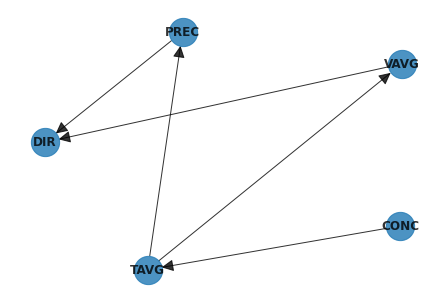

In [114]:
scoring_method = K2Score(data=pollen_data)
est = HillClimbSearch(data=pollen_data)
estimated_model = est.estimate(scoring_method=scoring_method,
                               max_indegree=4, max_iter=int(1e4))

nx.draw(estimated_model, with_labels=True, arrowsize=25,
        node_size=800, alpha=0.8, font_weight='bold')
plt.show()



### CPDs

In [115]:
bayesian_model = BayesianModel(estimated_model.edges())
bayesian_model.fit(pollen_data, estimator=MaximumLikelihoodEstimator)
for cpd in bayesian_model.get_cpds():
    print(cpd, "\n")


+---------+----------+
| CONC(0) | 0.451632 |
+---------+----------+
| CONC(1) | 0.149581 |
+---------+----------+
| CONC(2) | 0.198672 |
+---------+----------+
| CONC(3) | 0.200116 |
+---------+----------+ 

+---------+----------------------+---------------------+----------------------+----------------------+
| CONC    | CONC(0)              | CONC(1)             | CONC(2)              | CONC(3)              |
+---------+----------------------+---------------------+----------------------+----------------------+
| TAVG(0) | 0.17710997442455242  | 0.03861003861003861 | 0.0377906976744186   | 0.03896103896103896  |
+---------+----------------------+---------------------+----------------------+----------------------+
| TAVG(1) | 0.1636828644501279   | 0.0637065637065637  | 0.040697674418604654 | 0.050505050505050504 |
+---------+----------------------+---------------------+----------------------+----------------------+
| TAVG(2) | 0.14130434782608695  | 0.11003861003861004 | 0.04651162790

### Let's analyze what happens with some evidence
First let's set a very high value for average temperature.

In [116]:
exact_inference = VariableElimination(bayesian_model)
print(exact_inference.query(["CONC"], evidence={'TAVG': 9}))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------+-------------+
| CONC    |   phi(CONC) |
+=========+=============+
| CONC(0) |      0.2412 |
+---------+-------------+
| CONC(1) |      0.1794 |
+---------+-------------+
| CONC(2) |      0.3794 |
+---------+-------------+
| CONC(3) |      0.2000 |
+---------+-------------+


As we can see from the output the most probable case is a medium/high level of grass pollen
concentration.
Let's see now for a low average temperature what happens.

In [117]:
print(exact_inference.query(["CONC"], evidence={'TAVG': 2}))


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

+---------+-------------+
| CONC    |   phi(CONC) |
+=========+=============+
| CONC(0) |      0.6538 |
+---------+-------------+
| CONC(1) |      0.1686 |
+---------+-------------+
| CONC(2) |      0.0947 |
+---------+-------------+
| CONC(3) |      0.0828 |
+---------+-------------+


The probability is now in favor of a very low pollen concentration. So we can deduce that
warm temperature has some influence in pollen concentration.
Let's see the full spectrum now:

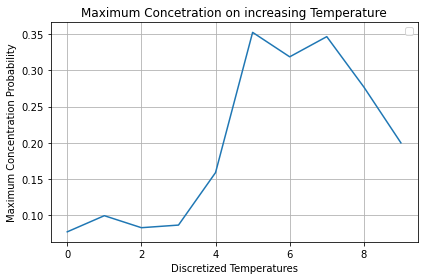

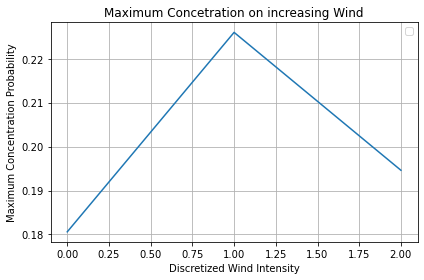

In [120]:
max_conc = []
for t in range(pollen_data['TAVG'].max() + 1):
    evidence = [State('TAVG', t)]
    prob = exact_inference.query(["CONC"], evidence=dict(evidence), show_progress=False)
    max_conc.append(prob.values[-1])

plt.plot(range(len(max_conc)), max_conc)
plt.title("Maximum Concetration on increasing Temperature")
plt.xlabel("Discretized Temperatures")
plt.ylabel("Maximum Concentration Probability")
plt.grid()
plt.legend([])
plt.tight_layout()
plt.show()

max_conc = []
for v in range(pollen_data['VAVG'].max() + 1):
    evidence = [State('VAVG', v)]
    prob = exact_inference.query(["CONC"], evidence=dict(evidence), show_progress=False)
    max_conc.append(prob.values[-1])

plt.plot(range(len(max_conc)), max_conc)
plt.title("Maximum Concetration on increasing Wind")
plt.xlabel("Discretized Wind Intensity")
plt.ylabel("Maximum Concentration Probability")
plt.grid()
plt.legend([])
plt.tight_layout()
plt.show()

### Approximate Inference
It is worth to try also the approximate inference techniques such as Likelihood Weighting.
The following function saves to an array the average error with respect to
exact inference. This will help plot the graph over increasing size of the sample, showing that
it will converge to a low value.

In [122]:
def test_approx_inference(query, evidence, bayesian_model,
                          min_samples=10, max_samples=10 ** 4, num_exp=10,
                          verbose=True):
    def abs_error(sample_probs, exact_probs):
        abs_error = sample_probs - exact_probs
        return np.where(abs_error > 0, abs_error, -abs_error)

    def find_probs(samples, weights):
        probs = np.zeros(len(np.unique(samples)))
        samples_list = list(samples)
        for index, s in enumerate(samples_list):
            probs[s] += weights[index]
        return probs / np.sum(weights)

    bayesian_model = bayesian_model
    sampler = BayesianModelSampling(bayesian_model)
    exact_inference = VariableElimination(bayesian_model)

    errors_lws = []
    exact_probs = exact_inference.query([query],
                                        dict(evidence),
                                        show_progress=False).values

    for size in range(min_samples, max_samples, (max_samples - min_samples) // num_exp):
        lws = sampler.likelihood_weighted_sample(size=size, evidence=evidence)
        lws_probs = find_probs(lws[query], lws['_weight'])
        lws_error = abs_error(lws_probs, exact_probs)
        errors_lws.append(np.mean(lws_error))
        if verbose:
            print(f"P({query} | {evidence}) =", exact_probs)
            print(f"With Likelihood Weighting after {size}"
                  f" samples: (error = {np.mean(lws_error):.2E})\n")
    return errors_lws


evidence = [State('TAVG', 8), State('VAVG', 2)]
err_list = test_approx_inference("CONC", evidence, bayesian_model)

Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 146.82it/s]


P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 10 samples: (error = 9.17E-02)

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 1009 samples: (error = 7.12E-03)

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 2008 samples: (error = 1.02E-02)

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 3007 samples: (error = 8.24E-03)



Generating for node: VAVG:   0%|          | 0/5 [00:00<?, ?it/s]

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 4006 samples: (error = 2.88E-03)

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 5005 samples: (error = 2.65E-03)

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 6004 samples: (error = 2.60E-03)



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 96.72it/s]


P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 7003 samples: (error = 5.11E-03)

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 8002 samples: (error = 3.69E-03)

P(CONC | [State(var='TAVG', state=8), State(var='VAVG', state=2)]) = [0.17714286 0.16857143 0.37714286 0.27714286]
With Likelihood Weighting after 9001 samples: (error = 3.12E-03)



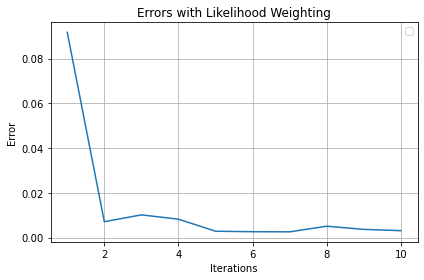

In [123]:
def print_errors(err_list):
    plt.plot(range(1, len(err_list) + 1), err_list)
    plt.title("Errors with Likelihood Weighting")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.grid()
    plt.legend([])
    plt.tight_layout()
    plt.show()


print_errors(err_list)